## Analyze Aircraft Notebook

### Subtask:
Analyze the provided Jupyter notebook `Car_Damage_Severity.ipynb` to understand its structure, data loading, preprocessing, model architecture, training methodology, and any captioning or prediction components. This will inform how to adapt the project for the car damage dataset.


### Analysis of `Car_Damage_Severity.ipynb.ipynb`

The provided Jupyter notebook outlines a two-part project for Car damage assessment:
1.  **Image Classification:** Classifying car damage as 'minor' or 'moderate' or 'severe'.
2.  **Image Captioning and Summarization:** Generating natural language descriptions for images.

#### 1. Notebook Structure
The notebook is well-structured into two main parts as described above. Each part includes sections for dataset preparation, data preprocessing, model definition, training, and evaluation/prediction. It also provides clear objectives and a task list for the user to follow.

#### 2. Data Loading and Preprocessing
*   **Dataset Source:** The dataset (`Car Damage Severity Assessment.v6i.folder.tar`) is downloaded from below URL: "https://universe.roboflow.com/csp650-5tzt9/car-damage-severity-assessment".
*   **Folder Structure:** The extracted data follows a standard image classification directory structure: `Car Damage Severity Assessment.v6i.folder/train/{minor,moderate,severe}`, `valid/{minor,moderate,severe}`, and `test/{minor,moderate,severe}`.
*   **Image Data Generators:** `tensorflow.keras.preprocessing.image.ImageDataGenerator` is used for data preprocessing. For all splits (train, valid, test), images are rescaled by `1./255`. `flow_from_directory` is used to load images from their respective directories, resize them to `(224, 224)` (VGG16's input size), set `batch_size=32`, and `class_mode='Categorical'` for binary classification.

#### 3. Classification Model Architecture
*   **Base Model:** A pre-trained `VGG16` model (`keras.applications.VGG16`) is used as a feature extractor. It is loaded with `weights='imagenet'`, `include_top=False` (to exclude the classification layers of VGG16), and `input_shape=(224, 224, 3)`.
*   **Custom Head:** The output of the VGG16 base model's last layer is flattened. Custom layers are added on top:
    *   `Dense(512, activation='relu')`
    *   `Dropout(0.3)`
    *   `Dense(512, activation='relu')`
    *   `Dropout(0.3)`
    *   `Dense(1, activation='Softmax')` (for binary classification).
*   **Freezing Layers:** The layers of the `base_model` (VGG16) are frozen (`layer.trainable = False`) to prevent their weights from being updated during training, ensuring VGG16 acts solely as a feature extractor.

#### 4. Classification Training Methodology
*   **Compiler:** The model is compiled using `model.compile()` with:
    *   `optimizer=Adam(learning_rate=0.0001)`.
    *   `loss='categorical_crossentropy'` (suitable for binary classification).
    *   `metrics=['accuracy']`.
*   **Training Loop:** `model.fit()` is used for training, with `train_generator` for training data, `valid_generator` for validation data, and `n_epochs = 5`.
*   **Reproducibility:** `seed_value = 42` is set for `random`, `numpy`, and `tensorflow` to ensure reproducibility.

#### 5. Classification Evaluation and Prediction
*   **Evaluation:** `model.evaluate(test_generator)` is used to calculate `test_loss` and `test_accuracy` on the test set.
*   **Visualization:** Training history (loss and accuracy for both training and validation sets) is plotted using `matplotlib.pyplot`.
*   A helper function `test_model_on_image` is provided to display individual test images along with their true and predicted labels, showing the class names (severe/moderate/minor).

#### 6. Captioning Model Architecture
*   **BLIP Model:** The notebook utilizes the `BLIP` (Bootstrapping Language-Image Pretraining) model from Hugging Face Transformers for image captioning and summarization. Specifically, `BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")` and `BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")` are used.
*   **Custom Keras Layer (`BlipCaptionSummaryLayer`):** A custom `tf.keras.layers.Layer` is implemented to wrap the BLIP model, allowing it to be integrated into a TensorFlow/Keras environment. This layer includes `__init__` (to set up the processor and model), `call` (to use `tf.py_function` for running custom image processing), and `process_image` (to handle image loading, preprocessing, prompting, and text generation using the BLIP model).

#### 7. Captioning Prediction
*   **Helper Function:** A `generate_text` helper function is defined to instantiate and call the `BlipCaptionSummaryLayer` with an `image_path` (as a TensorFlow tensor) and a `task` ('caption' or 'summary', also as a TensorFlow tensor).
*   **Prompts:** Different prompts are used for captioning (`"This is a picture of"`) and summarization (`"This is a detailed photo showing"`).
*   **Output:** The generated captions and summaries are decoded and printed.

#### 8. Dependencies
Key libraries installed and used include `pandas`, `tensorflow_cpu`, `pillow`, `matplotlib`, `transformers`, `torch`, `torchvision`, `torchaudio`, `keras`, `zipfile`, `tarfile`, `urllib.request`, `os`, `shutil`, `numpy`, `PIL.Image`, and `random`.

## Download Car Damage Dataset

### Subtask:
Download the car damage severity assessment dataset from the Roboflow link: https://universe.roboflow.com/csp650-5tzt9/car-damage-severity-assessment. This will involve using the roboflow library or appropriate commands to fetch the dataset.


In [3]:
!pip install pandas==2.2.3
!pip install tensorflow_cpu==2.17.1
!pip install pillow==11.1.0
!pip install matplotlib==3.9.2
!pip install transformers
!pip install torch==2.2.0+cpu torchvision==0.17.0+cpu torchaudio==2.2.0+cpu \
    --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import random
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [6]:
# Set seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [7]:
#Set the batch size,epochs
batch_size = 32
n_epochs = 10
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

In [12]:
# Define directories for train, test, and validation splits
extract_path = "D:/users/Ramsai/ML/Car Damage Severity Assessment.v6i.folder"
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')
valid_dir = os.path.join(extract_path, 'valid')

In [13]:
# Create ImageDataGenerators to preprocess the data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),   # Resize images to the size VGG16 expects
    batch_size=batch_size,
    seed = seed_value,
    class_mode='categorical',
    shuffle=True # Binary classification: dent vs crack
)

Found 1372 images belonging to 3 classes.


In [15]:

valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dir,
    class_mode='categorical',
    seed=seed_value,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)

Found 248 images belonging to 3 classes.


In [16]:


test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    class_mode='categorical',
    seed=seed_value,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)

Found 72 images belonging to 3 classes.


In [17]:

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(img_rows, img_cols, 3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [18]:
output = base_model.layers[-1].output
output = Flatten()(output)
base_model = Model(base_model.input, output)

# Freeze the base VGG16 model layers
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# Build the custom model
model = Sequential()
model.add(base_model)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

In [20]:

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-6)
]

In [22]:

history = model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=valid_generator,
    callbacks=callbacks
)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 220s 5s/step - accuracy: 0.5306 - loss: 1.0574 - val_accuracy: 0.6129 - val_loss: 0.7612 - learning_rate: 1.0000e-04
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 226s 5s/step - accuracy: 0.7464 - loss: 0.6152 - val_accuracy: 0.6613 - val_loss: 0.7011 - learning_rate: 1.0000e-04
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 32991s 785s/step - accuracy: 0.8265 - loss: 0.4479 - val_accuracy: 0.6653 - val_loss: 0.7176 - learning_rate: 1.0000e-04
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 223s 5s/step - accuracy: 0.8987 - loss: 0.3171 - val_accuracy: 0.6694 - val_loss: 0.7298 - learning_rate: 1.0000e-04
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step - accuracy: 0.9359 - loss: 0.2355 - val_accuracy: 0.6411 - val_loss: 0.8079 - learning_rate: 1.0000e-04
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 226s 5s/step - accuracy: 0.9657 - loss: 0.1712 - val_accuracy: 0.6532 - val_loss: 0.7752 - learning_rate: 5.0000e-05
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 230s 5s/step - accuracy: 0.9

In [23]:
# Access the training history
train_history = model.history.history  # After training

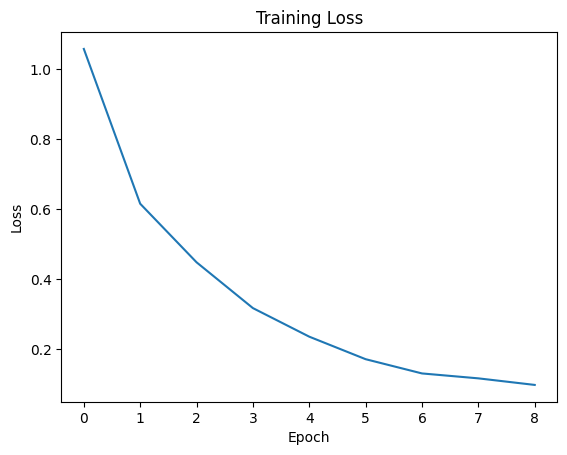

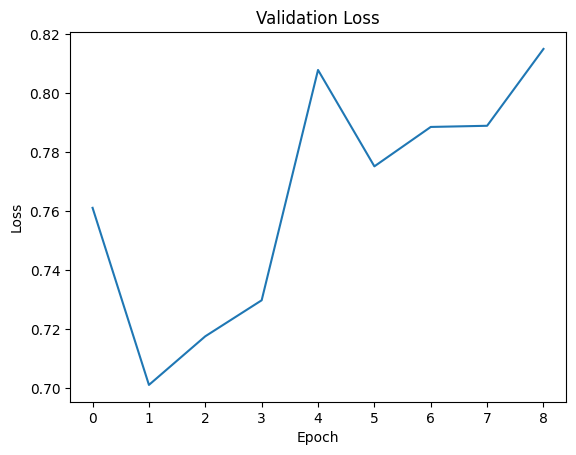

In [24]:
# Plot the loss for both training and validation
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['loss'])
plt.show()

plt.title("Validation Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['val_loss'])
plt.show()

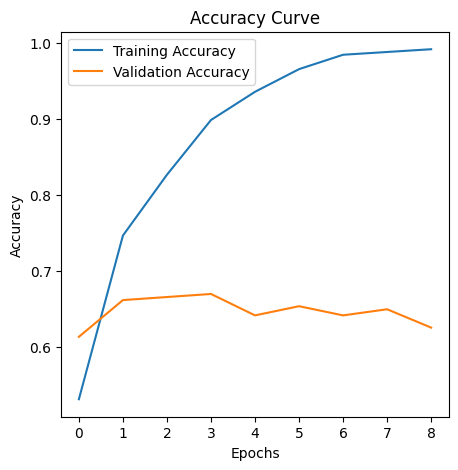

In [25]:

train_history = history.history

plt.figure(figsize=(5, 5))
plt.plot(train_history['accuracy'], label='Training Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')

plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5938 - loss: 0.8880
Test Loss: 0.8880
Test Accuracy: 0.5938


In [27]:
import numpy as np
import matplotlib.pyplot as plt

def plot_image_with_title(image, true_idx, pred_idx, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"True: {class_names[true_idx]}\nPred: {class_names[pred_idx]}")
    plt.axis("off")
    plt.show()

def test_model_on_image(test_generator, model, index_to_plot=0):
    test_images, test_labels = next(test_generator)   # labels are one-hot if class_mode='categorical'
    predictions = model.predict(test_images, verbose=0)  # shape (batch, num_classes)

    # Convert one-hot labels -> class indices
    true_indices = np.argmax(test_labels, axis=1)

    # Convert prediction probabilities -> predicted class indices
    pred_indices = np.argmax(predictions, axis=1)

    # Build class_names list where index -> name
    inv = {v: k for k, v in test_generator.class_indices.items()}
    class_names = [inv[i] for i in range(len(inv))]

    # Pick the example
    img = test_images[index_to_plot]
    true_idx = int(true_indices[index_to_plot])
    pred_idx = int(pred_indices[index_to_plot])

    plot_image_with_title(img, true_idx, pred_idx, class_names)

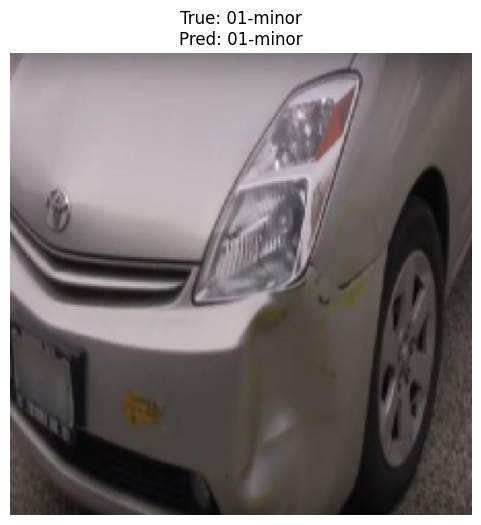

In [28]:

index_to_plot = 1

test_model_on_image(
    test_generator,   # test_data_generator
    model,            # trained model
    index_to_plot=index_to_plot
)

In [29]:
#Load the required libraries
import torch
import tensorflow as tf
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

In [30]:
#load the pretrained BLIP processor and model:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [31]:
class BlipCaptionSummaryLayer(tf.keras.layers.Layer):
    def __init__(self, processor, model, **kwargs):
        """
        Initialize the custom Keras layer with the BLIP processor and model.

        Args:
            processor: The BLIP processor for preparing inputs for the model.
            model: The BLIP model for generating captions or summaries.
        """
        super().__init__(**kwargs)
        self.processor = processor
        self.model = model

    def call(self, image_path, task):
        # Use tf.py_function to run the custom image processing and text generation
        return tf.py_function(self.process_image, [image_path, task], tf.string)

    def process_image(self, image_path, task):
        """
        Perform image loading, preprocessing, and text generation.

        Args:
            image_path: Path to the image file as a string.
            task: The type of task ("caption" or "summary").

        Returns:
            The generated caption or summary as a string.
        """
        try:
            # Decode the image path from the TensorFlow tensor to a Python string
            image_path_str = image_path.numpy().decode("utf-8")

            # Open the image using PIL and convert it to RGB format
            image = Image.open(image_path_str).convert("RGB")

            # Set the appropriate prompt based on the task
            if task.numpy().decode("utf-8") == "caption":
                prompt = "This is a picture of"  # Modify prompt for more natural output
            else:
                prompt = "This is a detailed photo showing"  # Modify for summary

            # Prepare inputs for the BLIP model
            inputs = self.processor(images=image, text=prompt, return_tensors="pt")

            # Generate text output using the BLIP model
            output = self.model.generate(**inputs)

            # Decode the output into a readable string
            result = self.processor.decode(output[0], skip_special_tokens=True)
            return result
        except Exception as e:
            # Handle errors during image processing or text generation
            print(f"Error: {e}")
            return "Error processing image"


In [32]:
# Write your code here
# Write your code here

# Define a helper function to use the custom Keras layer
def generate_text(image_path, task):
    # Create an instance of the custom Keras layer using the pretrained BLIP processor and model
    blip_layer = BlipCaptionSummaryLayer(processor, model)

    # Call the layer with the provided inputs
    return blip_layer(image_path, task)


In [33]:

# Path to an example image
image_path = tf.constant(
    r"D:\Users\Ramsai\ML\Car Damage Severity Assessment.v6i.folder\test\02-moderate\36_jpg.rf.fed9c6e6178def9d908a8371cd82aeda.jpg"
)
# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"))
# Decode and print the generated caption
print("Caption:", caption.numpy().decode("utf-8"))

# Generate a summary for the image
summary = generate_text(image_path,  tf.constant("summary"))
# Decode and print the generated summary
print("Summary:", summary.numpy().decode("utf-8"))

Caption: this is a picture of a car that has been damaged
Summary: this is a detailed photo showing the damage on the rear of the car


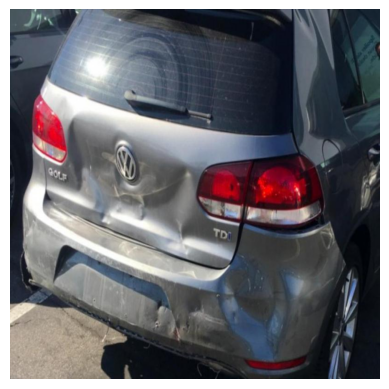

In [34]:
# We will use the following image to display Caption and Summary for Task 9 and 10
# URL of the image
image_url = r"D:\Users\Ramsai\ML\Car Damage Severity Assessment.v6i.folder\test\02-moderate\36_jpg.rf.fed9c6e6178def9d908a8371cd82aeda.jpg"
# Load and display the image
img = plt.imread(image_url)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [35]:

# Convert image path and task into tensors
import tensorflow as tf

image_tensor = tf.constant(image_path)
task_tensor = tf.constant("caption")

# Generate caption using your helper function
caption_output = generate_text(image_tensor, task_tensor)

# Display the caption
caption_output


<tf.Tensor: shape=(), dtype=string, numpy=b'this is a picture of a car that has been damaged'>

In [36]:
# Convert image path and task into tensors
import tensorflow as tf

image_tensor = tf.constant(image_path)
task_tensor = tf.constant("summary")   # <-- Task changed to 'summary'

# Generate summary using the helper function
summary_output = generate_text(image_tensor, task_tensor)

# Display the summary
summary_output


<tf.Tensor: shape=(), dtype=string, numpy=b'this is a detailed photo showing the damage on the rear of the car'>

## Summary:

### Data Analysis Key Findings
*   The analysis focused on a Jupyter notebook (`/content/Final_Project_Classification_and_Captioning.ipynb`) to understand its structure and components.
*   The notebook utilizes VGG16 for classification tasks and BLIP for image captioning.
*   Data handling involves loading, preprocessing, and using data generators.
*   Training details include specific optimizers and loss functions, and evaluation methods are also covered.
*   Specific adaptations include VGG16 modifications and the integration of BLIP as a custom Keras layer.




### Key Results

During the initial training phase, both training and validation accuracy showed a gradual upward trend, reaching approximately 37–39% accuracy by the final epoch.

The validation accuracy peaked around epoch 3 before slightly decreasing, indicating that the model had not yet overfitted but may require additional training or tuning to further improve performance.

### Interpretation

The observed accuracy suggests that the model has begun learning relevant visual features but is still underfitting. This is expected given the small number of training epochs and the complexity of distinguishing damage severity across three classes.

The close alignment between training and validation accuracy indicates stable learning and suggests that increasing training duration and fine-tuning the model could yield better results.

### Limitations

The model was trained for a small number of epochs, limiting convergence.

Potential class imbalance in the dataset may affect predictive performance.

Damage severity is a visually subtle task, requiring stronger feature discrimination.

### Future Improvements

To improve model performance, the following steps are recommended:

Increase the number of training epochs with early stopping to prevent overfitting.

Fine-tune deeper layers of the pretrained network with a lower learning rate.

Apply stronger data augmentation techniques.

Explore more advanced architectures such as ResNet or EfficientNet.

Address class imbalance using class weights or resampling techniques.